In [6]:
%matplotlib inline

In [7]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
'''!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip'''

'!wget https://download.pytorch.org/tutorial/data.zip\n!unzip data.zip'

In [9]:
'''!tail data/eng-fra.txt'''

'!tail data/eng-fra.txt'

In [10]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [11]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^-a-zA-Z.!?а-яёйЁА-Я]+", r" ", s)
    return s

In [12]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines if l !='']

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [13]:
_,_,p=readLangs('eng', 'rus')
(p[300])

Reading lines...


['go back .', 'иди обратно .']

In [14]:
len(p[444][0])

9

In [15]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    if len(p)==2:
        return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)
    else:
        return False



def filterPairs(pairs):
    return [pair for pair in pairs  if filterPair(pair)]

In [16]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        if len(pair)==2:
            input_lang.addSentence(pair[0])
            output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(input_lang, '\n',output_lang, '\n',random.choice(pairs))#



Reading lines...
Read 479223 sentence pairs
Trimmed to 27844 sentence pairs
Counting words...
Counted words:
rus 10125
eng 4320
 ['я удивлена не меньше твоего .', 'i am as surprised as you .']


In [17]:
for i in range(5):
    print(random.choice(pairs), '\n')

['мы несем стол в сад .', 'we re carrying the table to the garden .'] 

['ты совсем как твоя сестра .', 'you re just like your sister .'] 

['я впечатлен вашим французским .', 'i m impressed by your french .'] 

['вы идеально друг другу подходите .', 'you re perfect for each other .'] 

['вы единственная кого я тут знаю .', 'you re the only person i know here .'] 



In [18]:
'''emb = nn.Embedding(11, 1)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([0,1,2,3,4,5,6,7,8,9,10])
emb(input)'''

'emb = nn.Embedding(11, 1)\n# a batch of 2 samples of 4 indices each\ninput = torch.LongTensor([0,1,2,3,4,5,6,7,8,9,10])\nemb(input)'

The Encoder
-----------





In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        #инициализация при создании объекта класса input_size==n_words, hidden_size=256(размер выходного вектора энкодера)
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.LSTM(hidden_size, hidden_size,num_layers=2)

    def forward(self, input, hidden):
        #получили одно слово(тензор(-1,1)) из фразы в энкодер ==input_tensor[ei] и hidden==encoder_hidden = encoder.initHidden()
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device),torch.zeros(2, 1, self.hidden_size, device=device)

The Decoder
-----------




In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.LSTM(hidden_size, hidden_size,num_layers=2)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device),torch.zeros(2, 1, self.hidden_size, device=device)

In [21]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    #из фразы получаем тензор размерности [-1,1], где вместо -1 будет количество индексов слов из словаря
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [22]:
'''encoder_output, encoder_hidden = encoder1(torch.LongTensor([638]), torch.zeros(1, 1, 5, device=device))

encoder_output.shape, encoder_output.squeeze()# или encoder_output[0,0]'''

'encoder_output, encoder_hidden = encoder1(torch.LongTensor([638]), torch.zeros(1, 1, 5, device=device))\n\nencoder_output.shape, encoder_output.squeeze()# или encoder_output[0,0]'

In [23]:
teacher_forcing_ratio = 0.5

#input_tensor и target_tensor тензоры из индексов слов во входной и выходной фразах size==(-1,1) где -1 - индексы слов из словаря
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)  # размер input_tensor и target_tensor имеет право быть разным!
    target_length = target_tensor.size(0)# размер input_tensor и target_tensor имеет право быть разным!

    #encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        #подаём одно слово из фразы(одно чило из тензора) в энкодер ==input_tensor[ei]
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        #получаем выход == output, hidden = self.gru(output, hidden)

        #encoder_outputs[ei] = encoder_output[0, 0] # или encoder_output.squeeze()

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [24]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [25]:
'''tensorsFromPair(random.choice(pairs))[0][3,0]'''

'tensorsFromPair(random.choice(pairs))[0][3,0]'

In [26]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

    plt.title('Лосс', fontsize=15)

    '''plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)'''
    plt.legend()

    plt.show()

In [27]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    #получили список кортежей вх. и вых. фраз в виде тензоров (-1,1) где -1 - индексы слов из словаря
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]#   вх. фраз в виде тензоров (-1,1) где -1 - индексы слов из словаря
        target_tensor = training_pair[1]# вых. фраз в виде тензоров (-1,1) где -1 - индексы слов из словаря

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [28]:
'''import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()'''

"import matplotlib.pyplot as plt\nplt.switch_backend('agg')\nimport matplotlib.ticker as ticker\nimport numpy as np\n\n\ndef showPlot(points):\n    plt.figure()\n    fig, ax = plt.subplots()\n    # this locator puts ticks at regular intervals\n    loc = ticker.MultipleLocator(base=0.2)\n    ax.yaxis.set_major_locator(loc)\n    plt.plot(points)\n    plt.show()"

In [29]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [30]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 4s (- 15m 2s) (5000 6%) 3.3429
2m 4s (- 13m 32s) (10000 13%) 2.8864
3m 6s (- 12m 25s) (15000 20%) 2.6834
4m 7s (- 11m 20s) (20000 26%) 2.5153
5m 8s (- 10m 16s) (25000 33%) 2.3928
6m 9s (- 9m 14s) (30000 40%) 2.2687
7m 10s (- 8m 11s) (35000 46%) 2.1315
8m 11s (- 7m 10s) (40000 53%) 2.0371
9m 12s (- 6m 8s) (45000 60%) 1.9377
10m 14s (- 5m 7s) (50000 66%) 1.8272
11m 16s (- 4m 6s) (55000 73%) 1.7638
12m 17s (- 3m 4s) (60000 80%) 1.6884
13m 19s (- 2m 3s) (65000 86%) 1.6138
14m 21s (- 1m 1s) (70000 93%) 1.5226


15m 22s (- 0m 0s) (75000 100%) 1.4688


<Figure size 640x480 with 0 Axes>

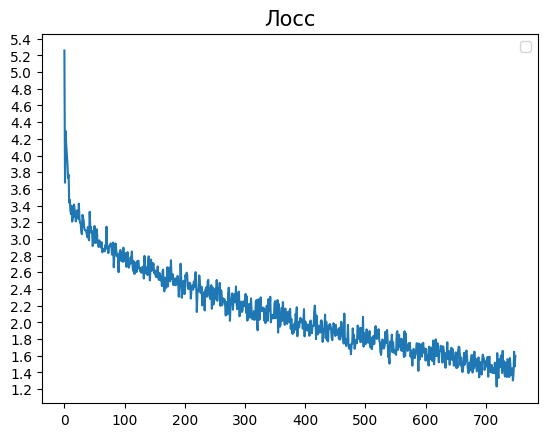

In [31]:

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder1, decoder1, 75000, print_every=5000)

In [32]:
evaluateRandomly(encoder1, decoder1)

> я уверен что вы хотели как лучше .
= i m sure you meant well .
< i m sure you like like better . <EOS>

> я это завтра починю .
= i m going to fix that tomorrow .
< i m going to do that tomorrow . <EOS>

> у нас закончилось сливочное масло .
= we re out of butter .
< we re out of the . . <EOS>

> я не такая как вы с томом .
= i m not like you and tom .
< i m not like you you . <EOS>

> мы определенно делаем успехи .
= we re definitely making progress .
< we re doing doing a . . <EOS>

> вы на меня даже не смотрите .
= you re not even looking at me .
< you re not even at i am . <EOS>

> я не жаворонок .
= i m not a morning person .
< i m not a bit . <EOS>

> ты готова .
= you re ready .
< you re ready . <EOS>

> он прямо за мнои .
= he s right behind me .
< he s right right . <EOS>

> ты очень плохои человек .
= you re a very bad person .
< you re a very bad person . <EOS>

